In [1]:
import pm4py
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay


In [2]:
def import_xes(file_path):
    log = pm4py.read_xes(file_path)
    event_log = pm4py.convert_to_dataframe(log)

    return event_log

event_log = import_xes("/Users/6706363/Downloads/BPI_Challenge_2013_incidents.xes")

/Users/6706363/PycharmProjects/PPM_NextResource/.venv/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/Users/6706363/PycharmProjects/PPM_NextResource/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 7554/7554 [00:03<00:00, 2505.77it/s]


In [5]:
event_log.columns

Index(['org:group', 'resource country', 'organization country', 'org:resource',
       'organization involved', 'org:role', 'concept:name', 'impact',
       'product', 'lifecycle:transition', 'time:timestamp',
       'case:concept:name'],
      dtype='object')

In [3]:
df = event_log[['case:concept:name', 'concept:name', 'org:resource', 'time:timestamp', 'org:role']]

# Sort by 'time:timestamp' and 'case:concept:name'
df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

df.head(n=10)

df["org:role"].nunique()



23

In [36]:
def create_activity_resource_sequence(df, prefix_length):
    sequences = []
    grouped = df.groupby('case:concept:name')
    
    for _, group in grouped:
        activities = group['concept:name'].tolist()
        resources = group['org:role'].tolist()
        
        # Only include sequences with length >= prefix_length
        if len(activities) < prefix_length:
            # Remove the sequence (skip appending it to the list)
            continue
        
        # Truncate to the desired prefix length
        current_activities = activities[:prefix_length]
        current_resources = resources[:prefix_length]  # Include all resources
        
        # Combine activities and resources into tuples (no changes for the last activity)
        sequence = []
        for i in range(len(current_activities)):
            # For all activities, include both activity and resource
            sequence.append((current_activities[i], current_resources[i]))
        
        # Add the valid sequence to the list
        sequences.append(sequence)
    
    return sequences

sequences = create_activity_resource_sequence(df, 35)

# Initialize a set to store unique 'R' values
unique_R = set()

# Loop through the list of sequences and extract the 'R' values
for sequence in sequences:
    for item in sequence:
        # item[1] is the second element (the part with 'R')
        unique_R.add(item[1])

# The length of the set will give the number of unique occurrences of 'R'
print(len(unique_R))

20


In [37]:
# Prepare the list of activities and resources
activities = []
resources = []

# Loop through sequences to gather activities and resources
for seq in sequences:
    for i, item in enumerate(seq):
        activity, resource = item  # Each item is (activity, resource)
        # Replace NaN resource with 'none'
        if pd.isna(resource):  # Check if the resource is NaN
            resource = 'none'
        activities.append(activity)
        resources.append(resource)

# Fit the OneHotEncoder to the unique activities and resources
activity_encoder = OneHotEncoder() 
resource_encoder = OneHotEncoder()

# Fit the encoder on unique activities and resources
activity_encoder.fit([[activity] for activity in set(activities)])
resource_encoder.fit([[resource] for resource in set(resources)])

# Encode activities and resources
encoded_sequences = []
y_encoded = []  # List to store the one-hot encoded target resource for the last activity

for seq in sequences:
    activity_onehots = []
    
    # For each activity-resource pair, apply one-hot encoding
    for i, item in enumerate(seq):
        activity, resource = item
        # Replace NaN resource with 'none' during encoding
        if pd.isna(resource):  # Check if the resource is NaN
            resource = 'none'
        activity_onehot = activity_encoder.transform([[activity]]).toarray()
        
        # If it's the last item, we only encode the activity and store the resource for y
        if i == len(seq) - 1:
            # Add only the activity one-hot encoding
            activity_onehots.append(activity_onehot)
            # One-hot encode the resource and store it for prediction (y)
            resource_onehot = resource_encoder.transform([[resource]]).toarray()
            y_encoded.append(resource_onehot)  # Store the one-hot encoded resource
        else:
            # For all other activities, include both activity and resource one-hot encoding
            resource_onehot = resource_encoder.transform([[resource]]).toarray()
            encoded_sequence = np.hstack([activity_onehot, resource_onehot])
            activity_onehots.append(encoded_sequence)
    
    # If there is more than one activity in the sequence, add the zero vector for the last resource
    if len(seq) > 1:
        last_activity_onehot = activity_onehots[-1]
        last_resource_onehot = np.zeros(resource_onehot.shape)  # Zero vector for the last resource
        activity_onehots[-1] = np.hstack([last_activity_onehot, last_resource_onehot])
    
    # Concatenate the encoded activities and resources for the full sequence
    encoded_sequences.append(np.vstack(activity_onehots))

X = np.array(encoded_sequences)
y = np.array(y_encoded)

print(X.shape)
print(y.shape)

X[0]

(105, 35, 23)
(105, 1, 20)


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0.,

In [38]:
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform([np.argmax(y_i) for y_i in y])


Class Distribution:
11    29
0     28
12    12
5     11
7      7
1      5
4      4
6      3
10     2
9      1
3      1
2      1
8      1
Name: count, dtype: int64


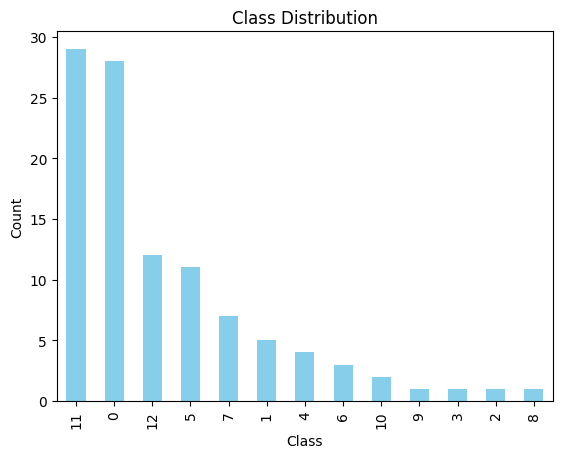


Class Proportions:
11    0.276190
0     0.266667
12    0.114286
5     0.104762
7     0.066667
1     0.047619
4     0.038095
6     0.028571
10    0.019048
9     0.009524
3     0.009524
2     0.009524
8     0.009524
Name: count, dtype: float64
Imbalance Ratio: 29.00


In [39]:
# Check class distribution
class_distribution = pd.Series(y_labels).value_counts()
print("Class Distribution:")
print(class_distribution)

# Visualize the class distribution
import matplotlib.pyplot as plt
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Calculate and print proportions
total = class_distribution.sum()
proportions = class_distribution / total
print("\nClass Proportions:")
print(proportions)

imbalance_ratio = class_distribution.max() / class_distribution.min()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

In [40]:
# Flatten the sequences as you did before
X_flattened = np.array([seq.sum(axis=0) for seq in X])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring={'f1_weighted': make_scorer(f1_score, average='weighted')},  # F1 weighted as scoring metric
    refit='f1_weighted',  # Refit using the best scoring parameter combination
    cv=kf,  # Cross-validation strategy
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_flattened, y_labels)

# Print the best parameters and corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Weighted Score:", grid_search.best_score_)

# Use the best classifier for evaluation
best_clf = grid_search.best_estimator_

# Perform cross-validation with the best estimator
cv_results = cross_validate(
    best_clf, X_flattened, y_labels,
    cv=kf,
    scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
    return_train_score=False
)

# Print cross-validation metrics with four decimal places
print("Cross-Validation Results:")
print("Accuracy (mean ± std): {:.4f} ± {:.4f}".format(np.mean(cv_results['test_accuracy']), np.std(cv_results['test_accuracy'])))
print("Precision (mean ± std): {:.4f} ± {:.4f}".format(np.mean(cv_results['test_precision_weighted']), np.std(cv_results['test_precision_weighted'])))
print("Recall (mean ± std): {:.4f} ± {:.4f}".format(np.mean(cv_results['test_recall_weighted']), np.std(cv_results['test_recall_weighted'])))
print("F1 (mean ± std): {:.4f} ± {:.4f}".format(np.mean(cv_results['test_f1_weighted']), np.std(cv_results['test_f1_weighted'])))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
Best F1-Weighted Score: 0.49464527535956104
Cross-Validation Results:
Accuracy (mean ± std): 0.5048 ± 0.0774
Precision (mean ± std): 0.5624 ± 0.1044
Recall (mean ± std): 0.5048 ± 0.0774
F1 (mean ± std): 0.4946 ± 0.0862


/Users/6706363/PycharmProjects/PPM_NextResource/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/6706363/PycharmProjects/PPM_NextResource/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/6706363/PycharmProjects/PPM_NextResource/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

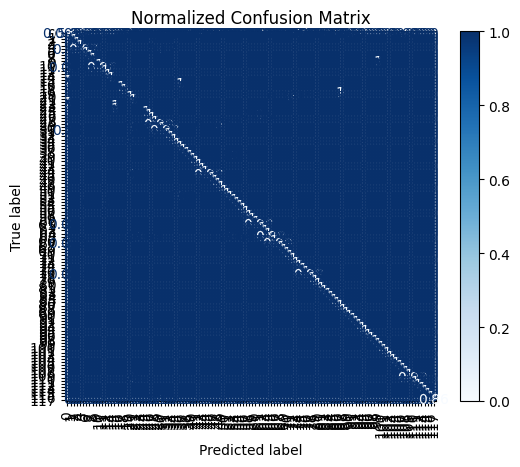

In [78]:
# Collect predictions and ground truth labels for confusion matrix
y_pred = cross_val_predict(best_clf, X_flattened, y_labels, cv=kf)
cm = confusion_matrix(y_labels, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Normalized Confusion Matrix")
plt.show()

In [77]:
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
cm_df.to_csv("confusion_matrix.csv") 